In [ ]:
!pip install -U tensorflow-gpu

     |████████████████████████████████| 320.4MB 37kB/s 


In [ ]:
!apt-get -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1  
!apt-get update  
!apt-get install --no-install-recommends nvidia-375  
!apt-get install --no-install-recommends nvidia-opencl-icd-375 nvidia-opencl-dev opencl-headers

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [94.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/pp

In [ ]:
!pip install -q keras

In [ ]:
!pip install tf-nightly-gpu 


     |████████████████████████████████| 345.5MB 35kB/s 
     |████████████████████████████████| 460kB 42.4MB/s 
     |████████████████████████████████| 8.9MB 28.9MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
import tensorflow as tf
# import tools.image_gen_extended as T
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

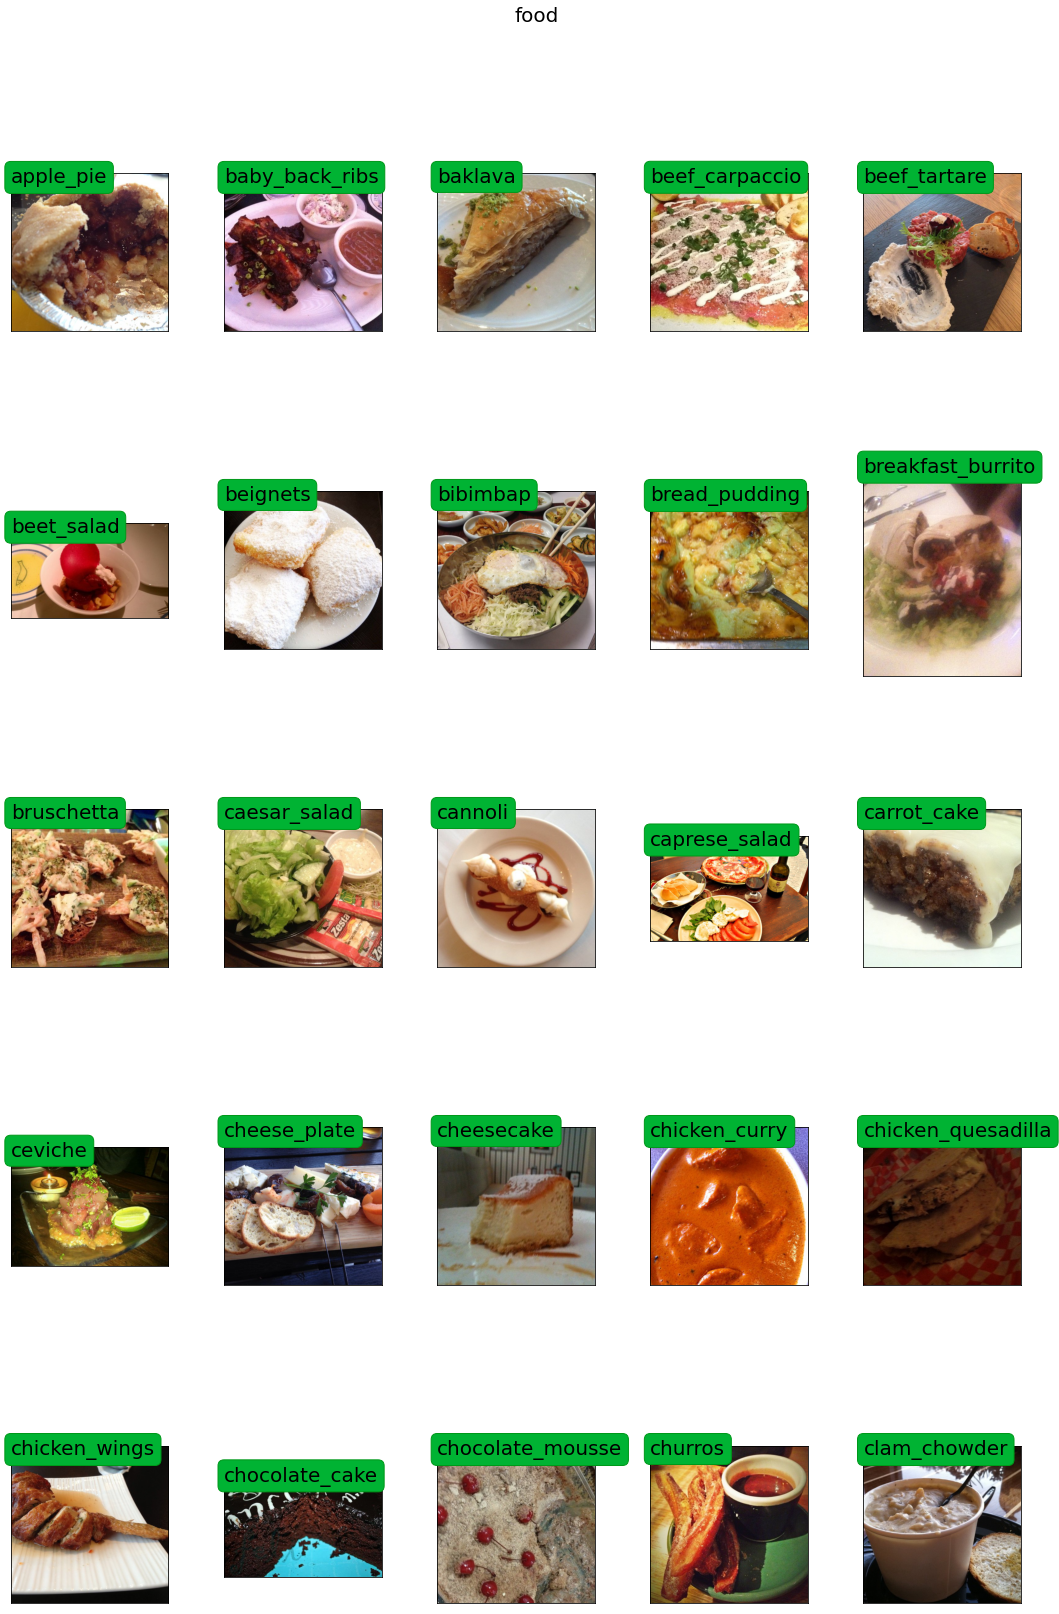

In [7]:
root_dir = r'/content/drive/My Drive/train/'
rows = 5
cols = 5
fig, ax = plt.subplots(rows, cols,  figsize=(15, 25))
fig.suptitle('food', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
# print(sorted_food_dirs)
for i in range(rows):
    for j in range(cols):
        food_dir = sorted_food_dirs[i*cols + j]
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=20, rotation=0,
                ha="left", va="top",
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [17]:


BATCH_SIZE = 16
INPUT_SIZE = (160,160)
EPOCH = 30
n_classes = 101
TRAIN_PATH = '/content/drive/My Drive/train/'
TEST_PATH = '/content/drive/My Drive/test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                  samplewise_std_normalization=False,  # divide each input by its std
                                   zoom_range=[.8, 1],
                                   rotation_range=45,
#                                    zca_whitening=True,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   channel_shift_range=30,
                                   fill_mode='reflect'
                                  )

#train_datagen.config['random_crop_size'] = (299, 299)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=INPUT_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                   seed=11
                                                   )

val_generator = train_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                               seed=11
                                                   )



Found 75711 images belonging to 101 classes.
Found 25229 images belonging to 101 classes.


In [22]:



base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, kernel_initializer='glorot_uniform',kernel_regularizer =l2(.0005), activation='softmax')(x)



model = tf.keras.Model(base_model.input, predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // BATCH_SIZE,
                              validation_data = val_generator,
                              validation_steps = val_generator.samples // BATCH_SIZE,
                              epochs=32,
                              verbose=1,
                              callbacks=[lr_scheduler, csv_logger, checkpointer])